In [0]:
import numpy as np
import pandas as pd
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
import timeit
import time
from keras.optimizers import RMSprop

In [130]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

num_classes = 10
epochs = 20


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
history=model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 16s 146us/step - loss: 0.0963 - accuracy: 0.8839 - val_loss: 0.0453 - val_accuracy: 0.9466
Epoch 2/20
108400/108400 [==============================] - 7s 64us/step - loss: 0.0412 - accuracy: 0.9580 - val_loss: 0.0305 - val_accuracy: 0.9676
Epoch 3/20
108400/108400 [==============================] - 7s 64us/step - loss: 0.0281 - accuracy: 0.9724 - val_loss: 0.0276 - val_accuracy: 0.9699
Epoch 4/20
108400/108400 [==============================] - 7s 63us/step - loss: 0.0224 - accuracy: 0.9772 - val_loss: 0.0250 - val_accuracy: 0.9730
Epoch 5/20
108400/108400 [==============================] - 7s 64us/step - loss: 0.0191 - accuracy: 0.9806 - val_loss: 0.0236 - val_accuracy: 0.9735
Epoch 6/20
108400/108400 [==============================] - 7s 65us/step - loss: 0.0169 - accuracy: 0.9827 - val_loss: 0.0219 - val_accuracy: 0.9755
Epoch 7/20
108400/108400 [===========================

In [107]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.recurrent import SimpleRNN, LSTM, GRU 
from keras.utils import np_utils
from keras import backend as K

from distutils.version import LooseVersion as LV
from keras import __version__

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using Keras version: 2.2.5 backend: tensorflow


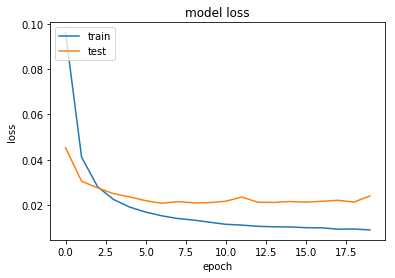

In [131]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [114]:
history

Text(0.5, 1.0, 'Accuracy Curves')

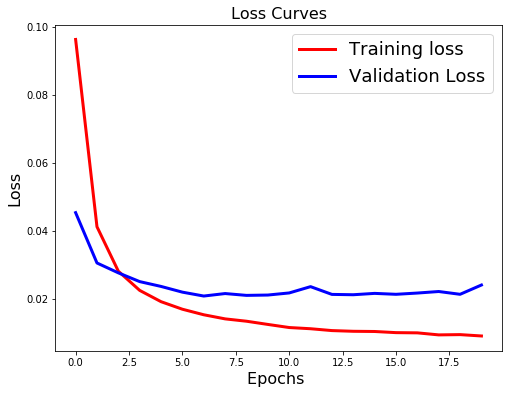

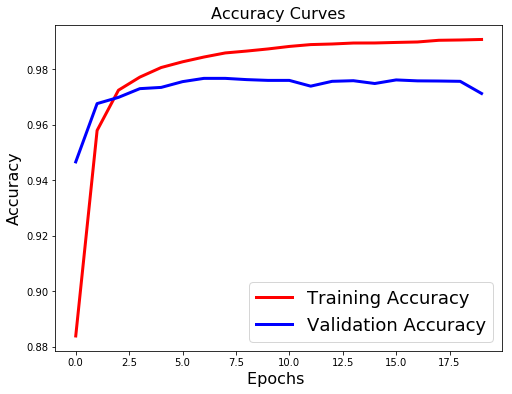

In [134]:



# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [139]:
# study of learning rate on accuracy for blobs problem
from sklearn.datasets.samples_generator import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from matplotlib import pyplot
 

 
# fit a model and plot learning curve
def fit_model(x_train, y_train, x_test, y_test, lrate):
	# define model
  base_network = create_base_network(input_shape)

  input_a = Input(shape=input_shape)
  input_b = Input(shape=input_shape)

  # because we re-use the same instance `base_network`,
  # the weights of the network
  # will be shared across the two branches
  processed_a = base_network(input_a)
  processed_b = base_network(input_b)

  distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

  model = Model([input_a, input_b], distance)

  # train

  # compute final accuracy on training and test sets
  y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
  tr_acc = compute_accuracy(tr_y, y_pred)
  y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
  te_acc = compute_accuracy(te_y, y_pred)

  print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
  print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))


  
  # compile model
  opt = SGD(lr=lrate)
  model.compile(loss=contrastive_loss, optimizer=opt, metrics=['accuracy'])
  # fit model
  start = timeit.default_timer()
  history=model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))
  stop = timeit.default_timer()
  y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
  tr_acc = compute_accuracy(tr_y, y_pred)
  y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
  te_acc = compute_accuracy(te_y, y_pred)

  print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
  print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

  print("Execution time", stop-start)
  # plot learning curves
  pyplot.plot(history.history['acc'], label='train')
  pyplot.plot(history.history['val_acc'], label='test')
  pyplot.ylabel('Accuracy')
  pyplot.xlabel('Epoch')
  pyplot.title('lrate='+str(lrate), pad=-50)
  pyplot.legend(['train', 'test'], loc='upper left')
  pyplot.figure(figsize=[8,6])
  pyplot.plot(history.history['loss'],'r')
  pyplot.plot(history.history['val_loss'],'b')
  pyplot.legend(['Training loss', 'Validation Loss'])
  pyplot.xlabel('Epochs ')
  pyplot.ylabel('Loss')
  pyplot.title('Loss Curves')
  pyplot.show()
  

learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
'''for i in range(len(learning_rates)):
	# determine the plot number
	plot_no = 420 + (i+1)
	pyplot.subplot(plot_no)
	# fit model and plot learning curves for a learning rate
	fit_model(x_train, y_train, x_test, y_test, learning_rates[i])
# show learning curves
pyplot.show() '''

'for i in range(len(learning_rates)):\n\t# determine the plot number\n\tplot_no = 420 + (i+1)\n\tpyplot.subplot(plot_no)\n\t# fit model and plot learning curves for a learning rate\n\tfit_model(x_train, y_train, x_test, y_test, learning_rates[i])\n# show learning curves\npyplot.show() '

* Accuracy on training set: 50.49%
* Accuracy on test set: 50.76%
Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 15s 140us/step - loss: 0.1110 - acc: 0.1418 - val_loss: 0.0604 - val_acc: 0.0705
Epoch 2/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.0654 - acc: 0.0754 - val_loss: 0.0505 - val_acc: 0.0607
Epoch 3/20
108400/108400 [==============================] - 6s 57us/step - loss: 0.0529 - acc: 0.0608 - val_loss: 0.0439 - val_acc: 0.0510
Epoch 4/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.0460 - acc: 0.0521 - val_loss: 0.0390 - val_acc: 0.0416
Epoch 5/20
108400/108400 [==============================] - 6s 57us/step - loss: 0.0419 - acc: 0.0466 - val_loss: 0.0381 - val_acc: 0.0447
Epoch 6/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.0382 - acc: 0.0419 - val_loss: 0.0357 - val_acc: 0.0374
Epoch 7/20
108400/108400 [=====================

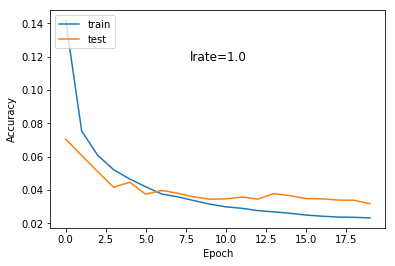

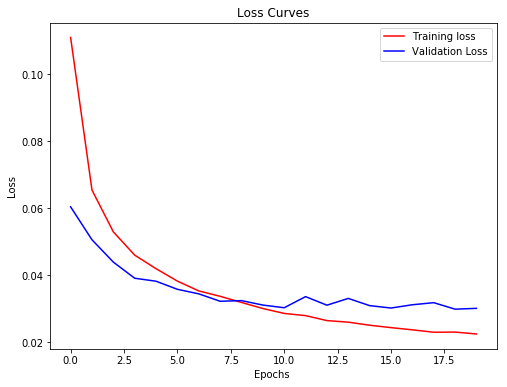

* Accuracy on training set: 50.24%
* Accuracy on test set: 50.35%
Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 15s 140us/step - loss: 0.1478 - acc: 0.1957 - val_loss: 0.0886 - val_acc: 0.1102
Epoch 2/20
108400/108400 [==============================] - 6s 60us/step - loss: 0.0953 - acc: 0.1081 - val_loss: 0.0708 - val_acc: 0.0882
Epoch 3/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.0793 - acc: 0.0870 - val_loss: 0.0628 - val_acc: 0.0782
Epoch 4/20
108400/108400 [==============================] - 7s 60us/step - loss: 0.0689 - acc: 0.0727 - val_loss: 0.0548 - val_acc: 0.0639
Epoch 5/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.0613 - acc: 0.0613 - val_loss: 0.0496 - val_acc: 0.0535
Epoch 6/20
108400/108400 [==============================] - 6s 57us/step - loss: 0.0555 - acc: 0.0525 - val_loss: 0.0453 - val_acc: 0.0474
Epoch 7/20
108400/108400 [=====================

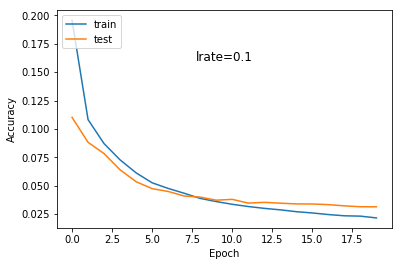

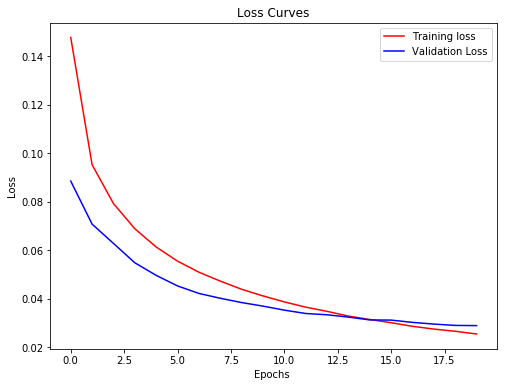

* Accuracy on training set: 50.24%
* Accuracy on test set: 50.39%
Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 15s 142us/step - loss: 0.2415 - acc: 0.3862 - val_loss: 0.1834 - val_acc: 0.2659
Epoch 2/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.1854 - acc: 0.2690 - val_loss: 0.1486 - val_acc: 0.1964
Epoch 3/20
108400/108400 [==============================] - 6s 57us/step - loss: 0.1613 - acc: 0.2138 - val_loss: 0.1299 - val_acc: 0.1625
Epoch 4/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.1455 - acc: 0.1833 - val_loss: 0.1189 - val_acc: 0.1452
Epoch 5/20
108400/108400 [==============================] - 6s 57us/step - loss: 0.1354 - acc: 0.1668 - val_loss: 0.1112 - val_acc: 0.1365
Epoch 6/20
108400/108400 [==============================] - 6s 57us/step - loss: 0.1283 - acc: 0.1554 - val_loss: 0.1058 - val_acc: 0.1292
Epoch 7/20
108400/108400 [=====================

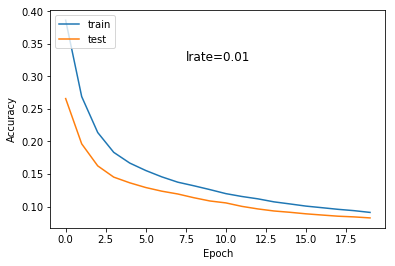

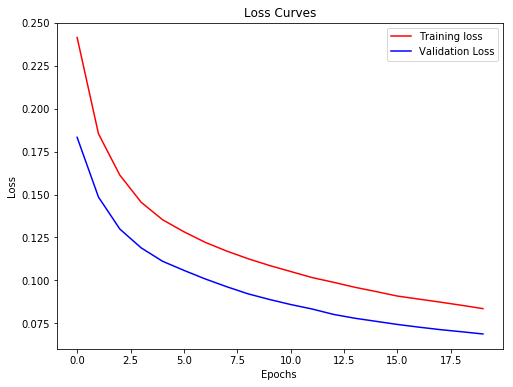

* Accuracy on training set: 51.16%
* Accuracy on test set: 51.91%
Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 16s 145us/step - loss: 0.3372 - acc: 0.4571 - val_loss: 0.2444 - val_acc: 0.4560
Epoch 2/20
108400/108400 [==============================] - 6s 57us/step - loss: 0.2497 - acc: 0.4500 - val_loss: 0.2463 - val_acc: 0.4646
Epoch 3/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.2458 - acc: 0.4411 - val_loss: 0.2405 - val_acc: 0.4474
Epoch 4/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.2418 - acc: 0.4257 - val_loss: 0.2324 - val_acc: 0.4143
Epoch 5/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.2368 - acc: 0.4071 - val_loss: 0.2240 - val_acc: 0.3810
Epoch 6/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.2320 - acc: 0.3922 - val_loss: 0.2164 - val_acc: 0.3567
Epoch 7/20
108400/108400 [=====================

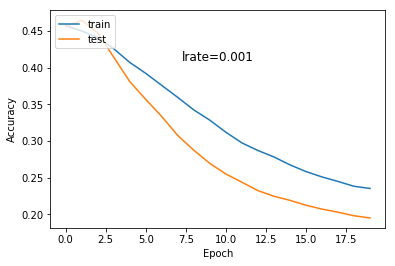

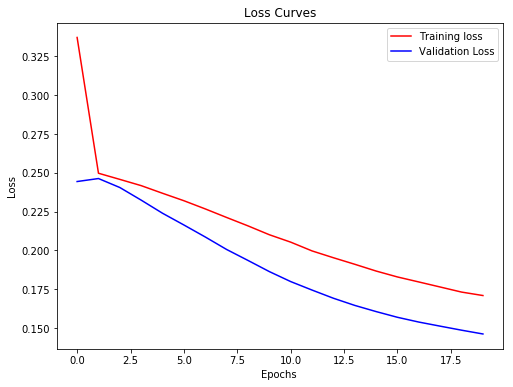

* Accuracy on training set: 50.38%
* Accuracy on test set: 50.68%
Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 16s 145us/step - loss: 0.8358 - acc: 0.4018 - val_loss: 0.3475 - val_acc: 0.4701
Epoch 2/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.4677 - acc: 0.4950 - val_loss: 0.2621 - val_acc: 0.4240
Epoch 3/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.3500 - acc: 0.4888 - val_loss: 0.2398 - val_acc: 0.3934
Epoch 4/20
108400/108400 [==============================] - 6s 60us/step - loss: 0.3022 - acc: 0.4756 - val_loss: 0.2344 - val_acc: 0.3909
Epoch 5/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.2802 - acc: 0.4656 - val_loss: 0.2342 - val_acc: 0.4012
Epoch 6/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.2681 - acc: 0.4564 - val_loss: 0.2355 - val_acc: 0.4140
Epoch 7/20
108400/108400 [=====================

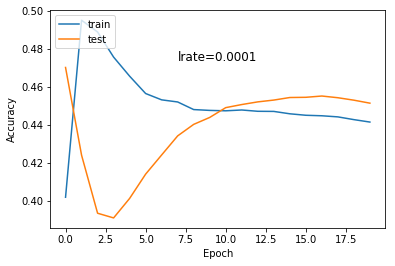

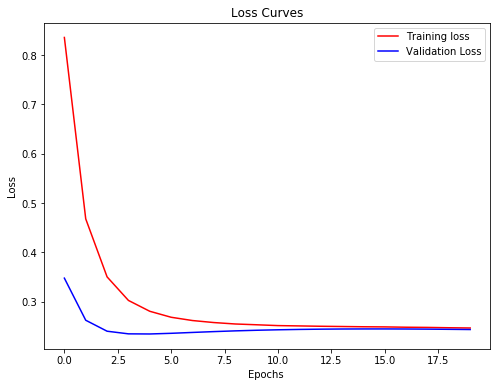

* Accuracy on training set: 50.32%
* Accuracy on test set: 50.56%
Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 16s 146us/step - loss: 1.1707 - acc: 0.2578 - val_loss: 0.6139 - val_acc: 0.4656
Epoch 2/20
108400/108400 [==============================] - 6s 59us/step - loss: 1.0483 - acc: 0.3105 - val_loss: 0.5599 - val_acc: 0.4761
Epoch 3/20
108400/108400 [==============================] - 6s 60us/step - loss: 0.9450 - acc: 0.3599 - val_loss: 0.5143 - val_acc: 0.4819
Epoch 4/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.8612 - acc: 0.3991 - val_loss: 0.4755 - val_acc: 0.4843
Epoch 5/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.7896 - acc: 0.4295 - val_loss: 0.4425 - val_acc: 0.4847
Epoch 6/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.7277 - acc: 0.4531 - val_loss: 0.4143 - val_acc: 0.4839
Epoch 7/20
108400/108400 [=====================

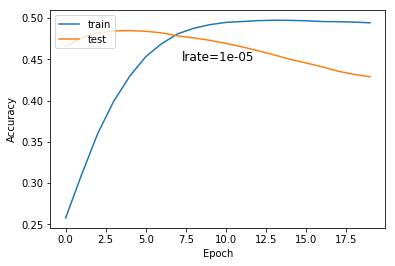

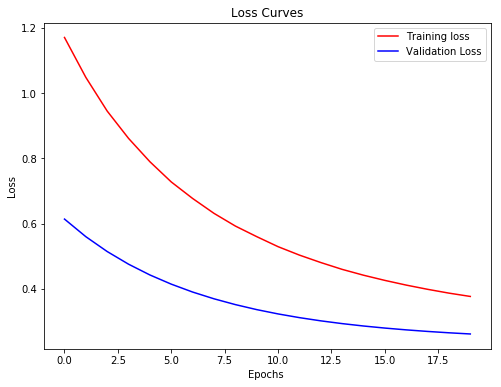

* Accuracy on training set: 50.33%
* Accuracy on test set: 50.53%
Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 16s 146us/step - loss: 1.3037 - acc: 0.2011 - val_loss: 0.6710 - val_acc: 0.4505
Epoch 2/20
108400/108400 [==============================] - 6s 60us/step - loss: 1.2894 - acc: 0.2061 - val_loss: 0.6645 - val_acc: 0.4524
Epoch 3/20
108400/108400 [==============================] - 6s 57us/step - loss: 1.2718 - acc: 0.2127 - val_loss: 0.6581 - val_acc: 0.4545
Epoch 4/20
108400/108400 [==============================] - 6s 57us/step - loss: 1.2590 - acc: 0.2164 - val_loss: 0.6518 - val_acc: 0.4561
Epoch 5/20
108400/108400 [==============================] - 6s 58us/step - loss: 1.2462 - acc: 0.2231 - val_loss: 0.6456 - val_acc: 0.4579
Epoch 6/20
108400/108400 [==============================] - 6s 57us/step - loss: 1.2339 - acc: 0.2274 - val_loss: 0.6396 - val_acc: 0.4599
Epoch 7/20
108400/108400 [=====================

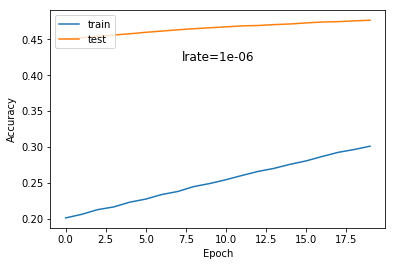

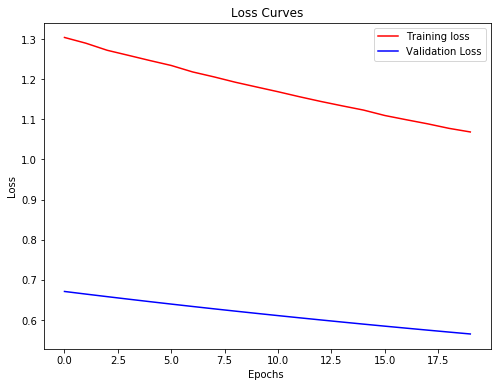

* Accuracy on training set: 50.27%
* Accuracy on test set: 50.40%
Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 16s 148us/step - loss: 1.5363 - acc: 0.1341 - val_loss: 0.7977 - val_acc: 0.4054
Epoch 2/20
108400/108400 [==============================] - 6s 59us/step - loss: 1.5319 - acc: 0.1343 - val_loss: 0.7970 - val_acc: 0.4058
Epoch 3/20
108400/108400 [==============================] - 6s 58us/step - loss: 1.5334 - acc: 0.1348 - val_loss: 0.7962 - val_acc: 0.4061
Epoch 4/20
108400/108400 [==============================] - 6s 58us/step - loss: 1.5303 - acc: 0.1353 - val_loss: 0.7955 - val_acc: 0.4065
Epoch 5/20
108400/108400 [==============================] - 6s 58us/step - loss: 1.5294 - acc: 0.1350 - val_loss: 0.7948 - val_acc: 0.4067
Epoch 6/20
108400/108400 [==============================] - 6s 59us/step - loss: 1.5265 - acc: 0.1357 - val_loss: 0.7940 - val_acc: 0.4072
Epoch 7/20
108400/108400 [=====================

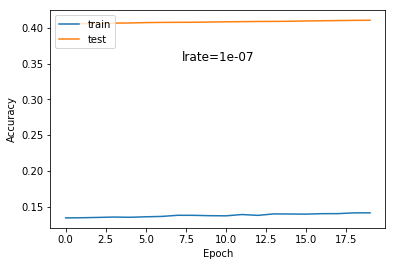

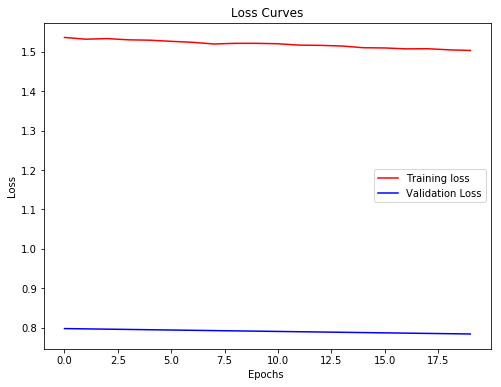

In [140]:
for i in range(len(learning_rates)):
  fit_model(x_train, y_train, x_test, y_test, learning_rates[i])


In [0]:
momentums = [0.0, 0.5, 0.9, 0.99]
def fit_model(x_train, y_train, x_test, y_test, momentum):
	# define model
  base_network = create_base_network(input_shape)

  input_a = Input(shape=input_shape)
  input_b = Input(shape=input_shape)

  # because we re-use the same instance `base_network`,
  # the weights of the network
  # will be shared across the two branches
  processed_a = base_network(input_a)
  processed_b = base_network(input_b)

  distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

  model = Model([input_a, input_b], distance)
  
  # compile model
  opt = SGD(lr=0.01,momentum=momentum)
  model.compile(loss=contrastive_loss, optimizer=opt, metrics=['accuracy'])
  # fit model
  start = timeit.default_timer()
  history=model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))
  stop = timeit.default_timer()
  y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
  tr_acc = compute_accuracy(tr_y, y_pred)
  y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
  te_acc = compute_accuracy(te_y, y_pred)
  print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
  print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

  
  print("Execution time", stop-start)
  # plot learning curves
  pyplot.plot(history.history['acc'], label='train')
  pyplot.plot(history.history['val_acc'], label='test')
  pyplot.ylabel('Accuracy')
  pyplot.xlabel('Epoch')
  pyplot.title('momentum='+str(momentum), pad=-50)
  pyplot.legend(['train', 'test'], loc='upper left')
  pyplot.figure(figsize=[8,6])
  pyplot.plot(history.history['loss'],'r')
  pyplot.plot(history.history['val_loss'],'b')
  pyplot.legend(['Training loss', 'Validation Loss'])
  pyplot.xlabel('Epochs ')
  pyplot.ylabel('Loss')
  pyplot.title('Loss Curves')
  pyplot.show()
  



Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 16s 151us/step - loss: 0.2447 - acc: 0.3991 - val_loss: 0.1875 - val_acc: 0.2688
Epoch 2/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.1895 - acc: 0.2736 - val_loss: 0.1513 - val_acc: 0.2017
Epoch 3/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.1640 - acc: 0.2191 - val_loss: 0.1345 - val_acc: 0.1727
Epoch 4/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.1493 - acc: 0.1908 - val_loss: 0.1228 - val_acc: 0.1559
Epoch 5/20
108400/108400 [==============================] - 6s 60us/step - loss: 0.1395 - acc: 0.1740 - val_loss: 0.1165 - val_acc: 0.1457
Epoch 6/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.1323 - acc: 0.1621 - val_loss: 0.1103 - val_acc: 0.1360
Epoch 7/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.1266 - acc: 0.1536 - val_loss:

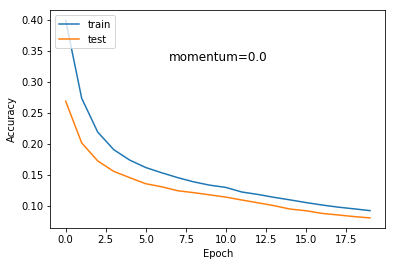

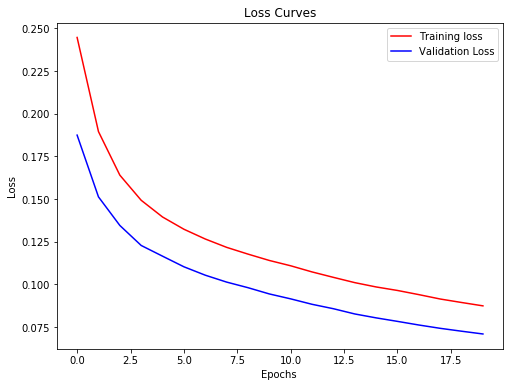

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 17s 152us/step - loss: 0.2169 - acc: 0.3399 - val_loss: 0.1502 - val_acc: 0.2036
Epoch 2/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.1567 - acc: 0.2065 - val_loss: 0.1208 - val_acc: 0.1570
Epoch 3/20
108400/108400 [==============================] - 6s 60us/step - loss: 0.1346 - acc: 0.1672 - val_loss: 0.1072 - val_acc: 0.1384
Epoch 4/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.1225 - acc: 0.1479 - val_loss: 0.0986 - val_acc: 0.1245
Epoch 5/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.1140 - acc: 0.1340 - val_loss: 0.0921 - val_acc: 0.1144
Epoch 6/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.1072 - acc: 0.1241 - val_loss: 0.0872 - val_acc: 0.1077
Epoch 7/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.1018 - acc: 0.1150 - val_loss:

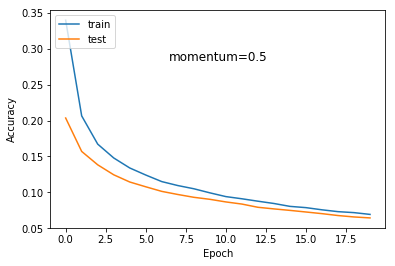

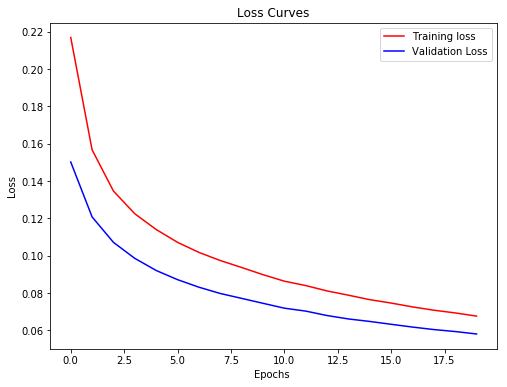

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 17s 155us/step - loss: 0.1570 - acc: 0.2103 - val_loss: 0.0914 - val_acc: 0.1161
Epoch 2/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.0991 - acc: 0.1130 - val_loss: 0.0724 - val_acc: 0.0874
Epoch 3/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.0824 - acc: 0.0902 - val_loss: 0.0628 - val_acc: 0.0742
Epoch 4/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.0718 - acc: 0.0766 - val_loss: 0.0562 - val_acc: 0.0674
Epoch 5/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.0646 - acc: 0.0680 - val_loss: 0.0518 - val_acc: 0.0615
Epoch 6/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.0585 - acc: 0.0601 - val_loss: 0.0472 - val_acc: 0.0512
Epoch 7/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.0543 - acc: 0.0539 - val_loss:

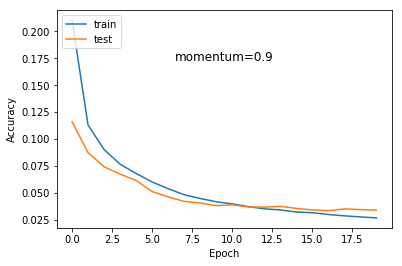

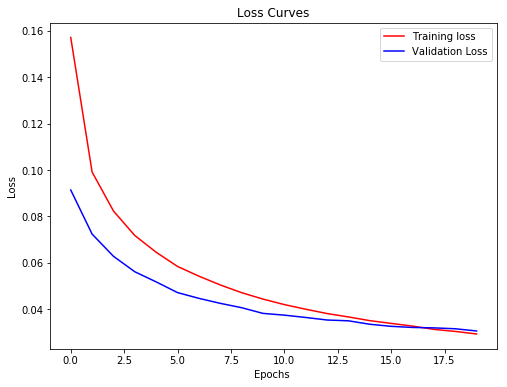

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 17s 159us/step - loss: 0.1301 - acc: 0.1724 - val_loss: 0.0731 - val_acc: 0.0865
Epoch 2/20
108400/108400 [==============================] - 7s 62us/step - loss: 0.0767 - acc: 0.0919 - val_loss: 0.0603 - val_acc: 0.0708
Epoch 3/20
108400/108400 [==============================] - 7s 61us/step - loss: 0.0677 - acc: 0.0813 - val_loss: 0.0554 - val_acc: 0.0663
Epoch 4/20
108400/108400 [==============================] - 7s 61us/step - loss: 0.0606 - acc: 0.0724 - val_loss: 0.0540 - val_acc: 0.0651
Epoch 5/20
108400/108400 [==============================] - 7s 61us/step - loss: 0.0567 - acc: 0.0691 - val_loss: 0.0472 - val_acc: 0.0580
Epoch 6/20
108400/108400 [==============================] - 7s 60us/step - loss: 0.0527 - acc: 0.0626 - val_loss: 0.0446 - val_acc: 0.0523
Epoch 7/20
108400/108400 [==============================] - 6s 60us/step - loss: 0.0491 - acc: 0.0571 - val_loss:

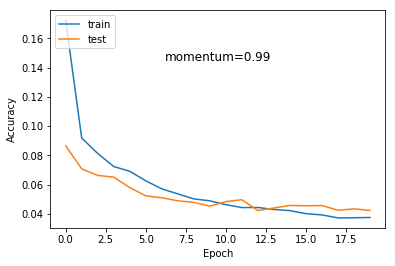

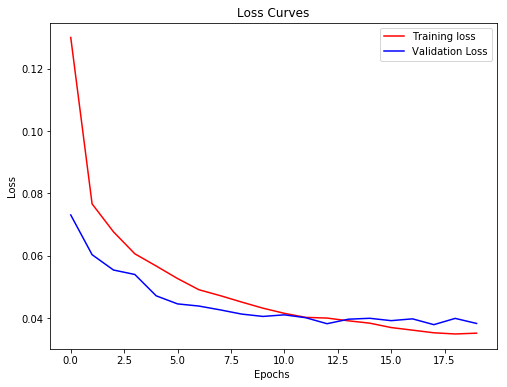

In [142]:
for i in range(len(momentums)):
  fit_model(x_train, y_train, x_test, y_test, momentums[i])


In [0]:
# learning rate decay
def decay_lrate(initial_lrate, decay, iteration):
	return initial_lrate * (1.0 / (1.0 + decay * iteration))

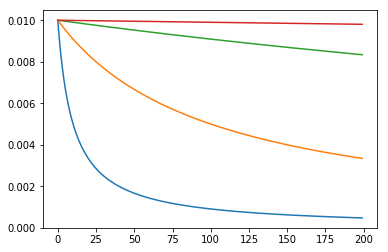

In [144]:
decays = [1E-1, 1E-2, 1E-3, 1E-4]
lrate = 0.01
n_updates = 200
for decay in decays:
	# calculate learning rates for updates
	lrates = [decay_lrate(lrate, decay, i) for i in range(n_updates)]
	# plot result
	pyplot.plot(lrates, label=str(decay))

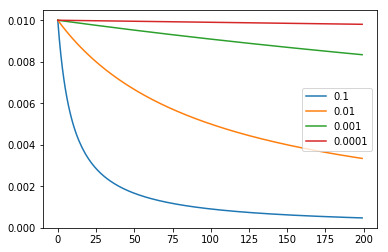

In [145]:
# demonstrate the effect of decay on the learning rate
from matplotlib import pyplot

# learning rate decay
def	decay_lrate(initial_lrate, decay, iteration):
	return initial_lrate * (1.0 / (1.0 + decay * iteration))

decays = [1E-1, 1E-2, 1E-3, 1E-4]
lrate = 0.01
n_updates = 200
for decay in decays:
	# calculate learning rates for updates
	lrates = [decay_lrate(lrate, decay, i) for i in range(n_updates)]
	# plot result
	pyplot.plot(lrates, label=str(decay))
pyplot.legend()
pyplot.show()

In [0]:
decay_rates = [1E-1, 1E-2, 1E-3, 1E-4]
def fit_model(x_train, y_train, x_test, y_test, decay):
	# define model
  base_network = create_base_network(input_shape)

  input_a = Input(shape=input_shape)
  input_b = Input(shape=input_shape)

  # because we re-use the same instance `base_network`,
  # the weights of the network
  # will be shared across the two branches
  processed_a = base_network(input_a)
  processed_b = base_network(input_b)

  distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

  model = Model([input_a, input_b], distance)
  
  # compile model
  opt = SGD(lr=0.01,decay=decay)
  model.compile(loss=contrastive_loss, optimizer=opt, metrics=['accuracy'])
  # fit model
  start = timeit.default_timer()
  history=model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))
  stop = timeit.default_timer()
  y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
  tr_acc = compute_accuracy(tr_y, y_pred)
  y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
  te_acc = compute_accuracy(te_y, y_pred)
  print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
  print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))
  
  print("Execution time", stop-start)
  # plot learning curves
  pyplot.plot(history.history['acc'], label='train')
  pyplot.plot(history.history['val_acc'], label='test')
  pyplot.ylabel('Accuracy')
  pyplot.xlabel('Epoch')
  pyplot.title('decay='+str(decay), pad=-80)
  pyplot.legend(['train', 'test'], loc='upper left')
  pyplot.figure(figsize=[8,6])
  pyplot.plot(history.history['loss'],'r')
  pyplot.plot(history.history['val_loss'],'b')
  pyplot.legend(['Training loss', 'Validation Loss'])
  pyplot.xlabel('Epochs ')
  pyplot.ylabel('Loss')
  pyplot.title('Loss Curves')
  pyplot.show()
  



Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 17s 160us/step - loss: 0.3042 - acc: 0.4740 - val_loss: 0.2343 - val_acc: 0.3972
Epoch 2/20
108400/108400 [==============================] - 7s 60us/step - loss: 0.2707 - acc: 0.4614 - val_loss: 0.2348 - val_acc: 0.4070
Epoch 3/20
108400/108400 [==============================] - 7s 61us/step - loss: 0.2658 - acc: 0.4581 - val_loss: 0.2353 - val_acc: 0.4125
Epoch 4/20
108400/108400 [==============================] - 7s 61us/step - loss: 0.2632 - acc: 0.4544 - val_loss: 0.2356 - val_acc: 0.4178
Epoch 5/20
108400/108400 [==============================] - 7s 60us/step - loss: 0.2619 - acc: 0.4540 - val_loss: 0.2359 - val_acc: 0.4202
Epoch 6/20
108400/108400 [==============================] - 6s 60us/step - loss: 0.2605 - acc: 0.4521 - val_loss: 0.2362 - val_acc: 0.4231
Epoch 7/20
108400/108400 [==============================] - 6s 60us/step - loss: 0.2600 - acc: 0.4536 - val_loss:

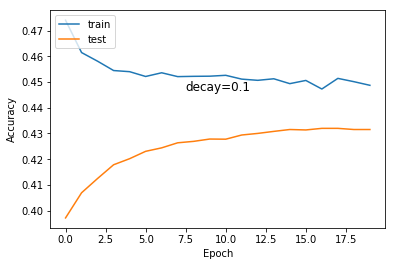

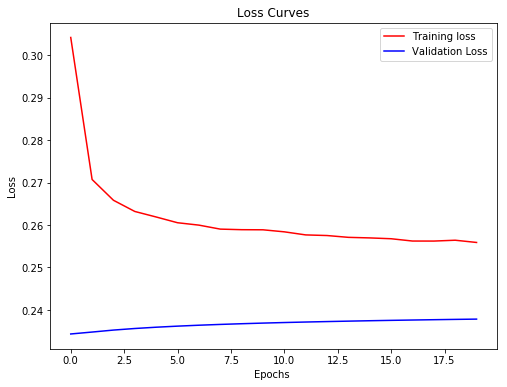

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 17s 161us/step - loss: 0.2630 - acc: 0.4370 - val_loss: 0.2362 - val_acc: 0.4247
Epoch 2/20
108400/108400 [==============================] - 7s 60us/step - loss: 0.2396 - acc: 0.4165 - val_loss: 0.2303 - val_acc: 0.4043
Epoch 3/20
108400/108400 [==============================] - 6s 60us/step - loss: 0.2368 - acc: 0.4090 - val_loss: 0.2265 - val_acc: 0.3910
Epoch 4/20
108400/108400 [==============================] - 7s 60us/step - loss: 0.2345 - acc: 0.4010 - val_loss: 0.2236 - val_acc: 0.3815
Epoch 5/20
108400/108400 [==============================] - 6s 60us/step - loss: 0.2333 - acc: 0.3981 - val_loss: 0.2217 - val_acc: 0.3736
Epoch 6/20
108400/108400 [==============================] - 7s 60us/step - loss: 0.2317 - acc: 0.3912 - val_loss: 0.2198 - val_acc: 0.3660
Epoch 7/20
108400/108400 [==============================] - 7s 60us/step - loss: 0.2309 - acc: 0.3886 - val_loss:

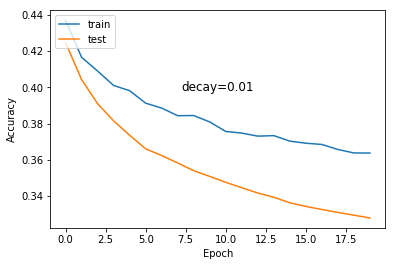

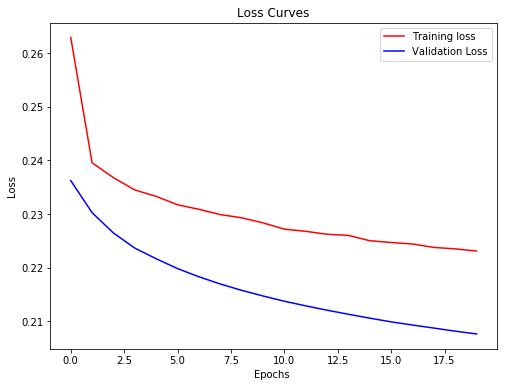

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 17s 161us/step - loss: 0.2491 - acc: 0.4217 - val_loss: 0.2091 - val_acc: 0.3274
Epoch 2/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.2105 - acc: 0.3300 - val_loss: 0.1769 - val_acc: 0.2487
Epoch 3/20
108400/108400 [==============================] - 6s 60us/step - loss: 0.1919 - acc: 0.2807 - val_loss: 0.1625 - val_acc: 0.2224
Epoch 4/20
108400/108400 [==============================] - 7s 61us/step - loss: 0.1816 - acc: 0.2561 - val_loss: 0.1544 - val_acc: 0.2083
Epoch 5/20
108400/108400 [==============================] - 6s 60us/step - loss: 0.1752 - acc: 0.2430 - val_loss: 0.1491 - val_acc: 0.1988
Epoch 6/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.1703 - acc: 0.2332 - val_loss: 0.1451 - val_acc: 0.1922
Epoch 7/20
108400/108400 [==============================] - 7s 60us/step - loss: 0.1668 - acc: 0.2255 - val_loss:

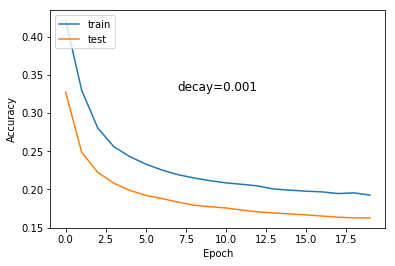

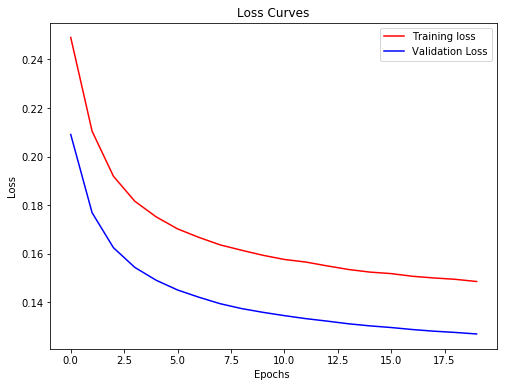

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 17s 160us/step - loss: 0.2435 - acc: 0.3910 - val_loss: 0.1825 - val_acc: 0.2562
Epoch 2/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.1862 - acc: 0.2658 - val_loss: 0.1452 - val_acc: 0.1913
Epoch 3/20
108400/108400 [==============================] - 6s 60us/step - loss: 0.1608 - acc: 0.2123 - val_loss: 0.1271 - val_acc: 0.1631
Epoch 4/20
108400/108400 [==============================] - 7s 60us/step - loss: 0.1468 - acc: 0.1876 - val_loss: 0.1173 - val_acc: 0.1499
Epoch 5/20
108400/108400 [==============================] - 7s 61us/step - loss: 0.1377 - acc: 0.1726 - val_loss: 0.1110 - val_acc: 0.1409
Epoch 6/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.1310 - acc: 0.1622 - val_loss: 0.1059 - val_acc: 0.1332
Epoch 7/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.1263 - acc: 0.1547 - val_loss:

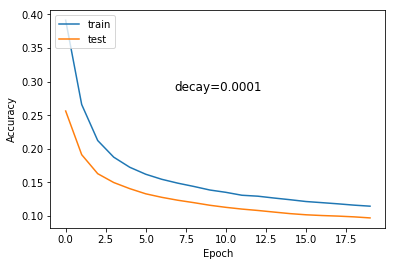

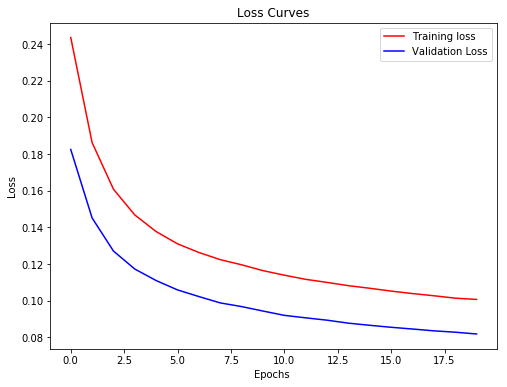

In [149]:
for i in range(len(decay_rates)):
  fit_model(x_train, y_train, x_test, y_test, decay_rates[i])


In [151]:
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau
from keras import backend
from matplotlib import pyplot

# monitor the learning rate
class LearningRateMonitor(Callback):
	# start of training
	def on_train_begin(self, logs={}):
		self.lrates = list()

	# end of each training epoch
	def on_epoch_end(self, epoch, logs={}):
		# get and store the learning rate
		optimizer = self.model.optimizer
		lrate = float(backend.get_value(self.model.optimizer.lr))
		self.lrates.append(lrate)




# fit a model and plot learning curve
def fit_model(x_train, y_train, x_test, y_test, patience):
	# define model
  base_network = create_base_network(input_shape)

  input_a = Input(shape=input_shape)
  input_b = Input(shape=input_shape)

  # because we re-use the same instance `base_network`,
  # the weights of the network
  # will be shared across the two branches
  processed_a = base_network(input_a)
  processed_b = base_network(input_b)

  distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

  model = Model([input_a, input_b], distance)
  
  # compile model
  
  # fit model
  
  
	# compile model
  opt = SGD(lr=0.01)
  model.compile(loss=contrastive_loss, optimizer=opt, metrics=['accuracy'])
	# fit model
  rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience, min_delta=1E-7)
  lrm = LearningRateMonitor()
  history=model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))
  return lrm.lrates, history.history['loss'], history.history['acc']

# create line plots for a series
def line_plots(patiences, series):
	for i in range(len(patiences)):
		pyplot.subplot(220 + (i+1))
		pyplot.plot(series[i])
		pyplot.title('patience='+str(patiences[i]), pad=-80)
	pyplot.show()

patiences = [2, 5, 10, 15]
lr_list, loss_list, acc_list, = list(), list(), list()
for i in range(len(patiences)):
	# fit model and plot learning curves for a patience
	lr, loss, acc = fit_model(x_train,y_train,x_test,y_test, patiences[i])
	lr_list.append(lr)
	loss_list.append(loss)
	acc_list.append(acc)
# plot learning rates
line_plots(patiences, lr_list)
# plot loss
line_plots(patiences, loss_list)
# plot accuracy
line_plots(patiences, acc_list)

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 18s 166us/step - loss: 0.2415 - acc: 0.3871 - val_loss: 0.1805 - val_acc: 0.2525
Epoch 2/20
108400/108400 [==============================] - 7s 60us/step - loss: 0.1838 - acc: 0.2607 - val_loss: 0.1450 - val_acc: 0.1900
Epoch 3/20
108400/108400 [==============================] - 6s 60us/step - loss: 0.1609 - acc: 0.2133 - val_loss: 0.1301 - val_acc: 0.1669
Epoch 4/20
108400/108400 [==============================] - 7s 60us/step - loss: 0.1469 - acc: 0.1873 - val_loss: 0.1209 - val_acc: 0.1559
Epoch 5/20
108400/108400 [==============================] - 6s 60us/step - loss: 0.1378 - acc: 0.1726 - val_loss: 0.1144 - val_acc: 0.1470
Epoch 6/20
108400/108400 [==============================] - 7s 61us/step - loss: 0.1309 - acc: 0.1620 - val_loss: 0.1087 - val_acc: 0.1379
Epoch 7/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.1251 - acc: 0.1534 - val_loss:

AttributeError: ignored

In [0]:
optimizer = ['sgd', 'rmsprop', 'adagrad', 'adam']
def fit_model(x_train, y_train, x_test, y_test, optimizer):
	# define model
  base_network = create_base_network(input_shape)

  input_a = Input(shape=input_shape)
  input_b = Input(shape=input_shape)

  # because we re-use the same instance `base_network`,
  # the weights of the network
  # will be shared across the two branches
  processed_a = base_network(input_a)
  processed_b = base_network(input_b)

  distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

  model = Model([input_a, input_b], distance)
  
  # compile model
  model.compile(loss=contrastive_loss, optimizer=optimizer, metrics=['accuracy'])
  # fit model
  start = timeit.default_timer()
  history=model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))
  stop = timeit.default_timer()
  y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
  tr_acc = compute_accuracy(tr_y, y_pred)
  y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
  te_acc = compute_accuracy(te_y, y_pred)
  print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
  print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))
  
  
  print("Execution time", stop-start)
  # plot learning curves
  pyplot.plot(history.history['acc'], label='train')
  pyplot.plot(history.history['val_acc'], label='test')
  pyplot.ylabel('Accuracy')
  pyplot.xlabel('Epoch')
  pyplot.title('optimizer='+str(optimizer), pad=-50)
  pyplot.legend(['train', 'test'], loc='upper left')
  pyplot.figure(figsize=[8,6])
  pyplot.plot(history.history['loss'],'r')
  pyplot.plot(history.history['val_loss'],'b')
  pyplot.legend(['Training loss', 'Validation Loss'])
  pyplot.xlabel('Epochs ')
  pyplot.ylabel('Loss')
  pyplot.title('Loss Curves')
  pyplot.show()
  



Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 18s 167us/step - loss: 0.2358 - acc: 0.3794 - val_loss: 0.1774 - val_acc: 0.2544
Epoch 2/20
108400/108400 [==============================] - 7s 61us/step - loss: 0.1821 - acc: 0.2590 - val_loss: 0.1436 - val_acc: 0.1936
Epoch 3/20
108400/108400 [==============================] - 7s 61us/step - loss: 0.1594 - acc: 0.2128 - val_loss: 0.1295 - val_acc: 0.1681
Epoch 4/20
108400/108400 [==============================] - 7s 61us/step - loss: 0.1462 - acc: 0.1856 - val_loss: 0.1204 - val_acc: 0.1519
Epoch 5/20
108400/108400 [==============================] - 7s 61us/step - loss: 0.1373 - acc: 0.1714 - val_loss: 0.1139 - val_acc: 0.1427
Epoch 6/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.1309 - acc: 0.1610 - val_loss: 0.1086 - val_acc: 0.1377
Epoch 7/20
108400/108400 [==============================] - 7s 61us/step - loss: 0.1256 - acc: 0.1532 - val_loss:

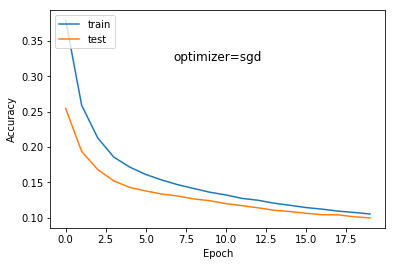

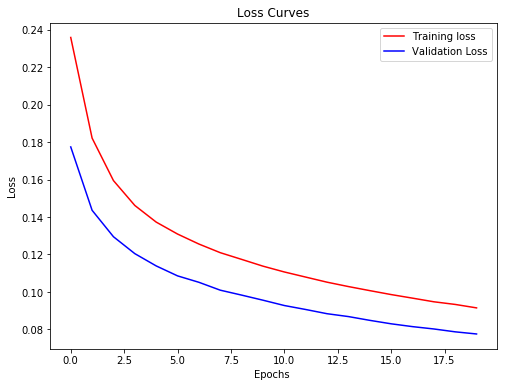

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 19s 172us/step - loss: 0.0935 - acc: 0.1107 - val_loss: 0.0448 - val_acc: 0.0470
Epoch 2/20
108400/108400 [==============================] - 7s 63us/step - loss: 0.0388 - acc: 0.0375 - val_loss: 0.0295 - val_acc: 0.0321
Epoch 3/20
108400/108400 [==============================] - 7s 64us/step - loss: 0.0266 - acc: 0.0279 - val_loss: 0.0258 - val_acc: 0.0310
Epoch 4/20
108400/108400 [==============================] - 7s 65us/step - loss: 0.0214 - acc: 0.0230 - val_loss: 0.0248 - val_acc: 0.0295
Epoch 5/20
108400/108400 [==============================] - 7s 66us/step - loss: 0.0185 - acc: 0.0203 - val_loss: 0.0237 - val_acc: 0.0291
Epoch 6/20
108400/108400 [==============================] - 7s 65us/step - loss: 0.0162 - acc: 0.0176 - val_loss: 0.0233 - val_acc: 0.0286
Epoch 7/20
108400/108400 [==============================] - 7s 64us/step - loss: 0.0146 - acc: 0.0159 - val_loss:

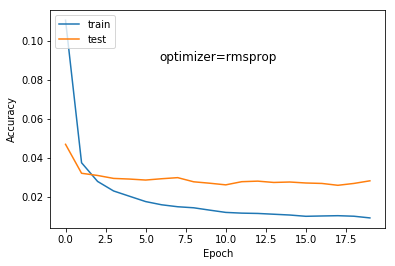

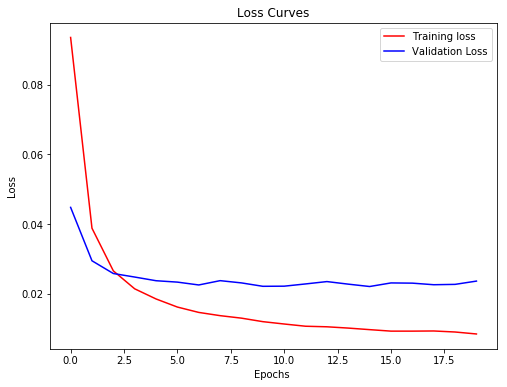

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 19s 175us/step - loss: 0.1060 - acc: 0.1236 - val_loss: 0.0602 - val_acc: 0.0653
Epoch 2/20
108400/108400 [==============================] - 7s 64us/step - loss: 0.0627 - acc: 0.0624 - val_loss: 0.0464 - val_acc: 0.0504
Epoch 3/20
108400/108400 [==============================] - 7s 63us/step - loss: 0.0498 - acc: 0.0483 - val_loss: 0.0399 - val_acc: 0.0422
Epoch 4/20
108400/108400 [==============================] - 7s 64us/step - loss: 0.0422 - acc: 0.0395 - val_loss: 0.0363 - val_acc: 0.0395
Epoch 5/20
108400/108400 [==============================] - 7s 64us/step - loss: 0.0375 - acc: 0.0345 - val_loss: 0.0338 - val_acc: 0.0363
Epoch 6/20
108400/108400 [==============================] - 7s 63us/step - loss: 0.0339 - acc: 0.0300 - val_loss: 0.0322 - val_acc: 0.0345
Epoch 7/20
108400/108400 [==============================] - 7s 64us/step - loss: 0.0309 - acc: 0.0274 - val_loss:

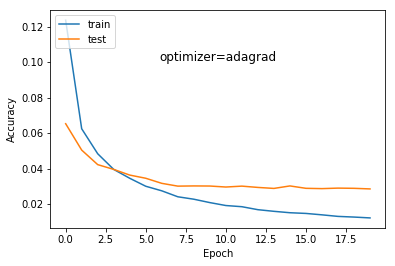

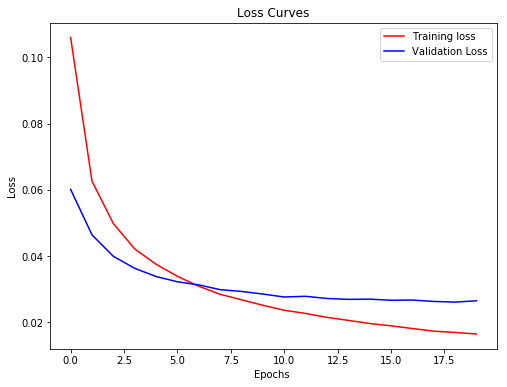

Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 19s 179us/step - loss: 0.1090 - acc: 0.1354 - val_loss: 0.0515 - val_acc: 0.0612
Epoch 2/20
108400/108400 [==============================] - 8s 71us/step - loss: 0.0487 - acc: 0.0510 - val_loss: 0.0370 - val_acc: 0.0381
Epoch 3/20
108400/108400 [==============================] - 7s 69us/step - loss: 0.0343 - acc: 0.0339 - val_loss: 0.0303 - val_acc: 0.0324
Epoch 4/20
108400/108400 [==============================] - 7s 68us/step - loss: 0.0272 - acc: 0.0271 - val_loss: 0.0299 - val_acc: 0.0322
Epoch 5/20
108400/108400 [==============================] - 7s 68us/step - loss: 0.0229 - acc: 0.0231 - val_loss: 0.0299 - val_acc: 0.0332
Epoch 6/20
108400/108400 [==============================] - 7s 68us/step - loss: 0.0202 - acc: 0.0200 - val_loss: 0.0265 - val_acc: 0.0295
Epoch 7/20
108400/108400 [==============================] - 7s 68us/step - loss: 0.0179 - acc: 0.0176 - val_loss:

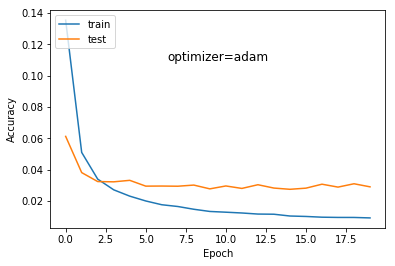

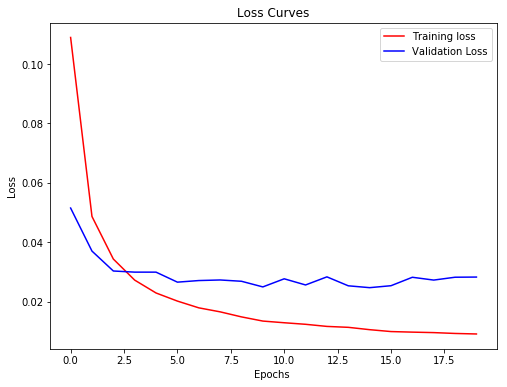

In [153]:
for i in range(len(optimizer)):
  fit_model(x_train, y_train, x_test, y_test, optimizer[i])
